# Damage Classification

In [114]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [113]:
#export
from xview2comp.nb_02c import *

### Data

In [115]:
SOURCE = Path('data/train')
SOURCE.ls()

[PosixPath('data/train/train.tar.gz'),
 PosixPath('data/train/images'),
 PosixPath('data/train/damagemasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/classification_images'),
 PosixPath('data/train/binarymasks')]

In [118]:
annots = pd.read_csv('class_labels_combined_cpu.csv')

In [119]:
annots.head(), annots.shape

(         damage                                   uid  \
 0  minor-damage  c112f7b8-bc78-41c2-bbaf-76045c5a63ec   
 1  minor-damage  700efd81-2bf7-4702-b89a-760cc723b1fa   
 2  minor-damage  613366fe-87b5-4653-87fe-cd1b4f3ffc6c   
 3  minor-damage  238f8100-b63d-4ee3-aa17-c3fcf1be21a0   
 4  minor-damage  6ef1c766-248f-4c69-93e6-23218b5210eb   
 
                                                 file   area  
 0  data/train/classification_images/c112f7b8-bc78...  42432  
 1  data/train/classification_images/700efd81-2bf7...  16488  
 2  data/train/classification_images/613366fe-87b5...  31768  
 3  data/train/classification_images/238f8100-b63d...  50193  
 4  data/train/classification_images/6ef1c766-248f...  22800  , (13530, 4))

In [120]:
annots.damage.value_counts()

major-damage               3645
minor-damage               3524
no-damage/un-classified    3385
destroyed                  2976
Name: damage, dtype: int64

In [128]:
fnames = [Path(o) for o in annots.file.values]
fnames[:3]

[PosixPath('data/train/classification_images/c112f7b8-bc78-41c2-bbaf-76045c5a63ec.png'),
 PosixPath('data/train/classification_images/700efd81-2bf7-4702-b89a-760cc723b1fa.png'),
 PosixPath('data/train/classification_images/613366fe-87b5-4653-87fe-cd1b4f3ffc6c.png')]

In [129]:
val_idx = get_random_val_idx(len(fnames))    

In [130]:
#export
def get_label(annots, fname): 
    return annots[annots.uid == fname.stem].damage.values[0]

In [131]:
cats = list(annots.damage.value_counts().index)
cats

['major-damage', 'minor-damage', 'no-damage/un-classified', 'destroyed']

In [132]:
src = (ImageList(fnames)
       .split_by_idx(val_idx)
       .label_from_func(partial(get_label, annots), classes=cats))

In [133]:
bs = 8
sz = 512 #64 #512
tfms = get_transforms(flip_vert=True, max_rotate=.2, max_warp=0., max_zoom=1.1, max_lighting=.4)
data = (src.transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [134]:
data

ImageDataBunch;

Train: LabelList (12177 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
minor-damage,minor-damage,minor-damage,minor-damage,minor-damage
Path: .;

Valid: LabelList (1353 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
major-damage,minor-damage,destroyed,no-damage/un-classified,destroyed
Path: .;

Test: None

major-damage
data/train/classification_images/90d18681-5e37-4744-80e1-2d122c8b7962.png


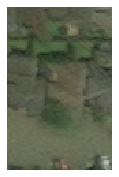

In [135]:
idx = 11
data.valid_ds.x[idx].show()
print(data.valid_ds.y[idx], data.valid_ds.items[idx], sep='\n')

In [136]:
data.train_ds.classes

['major-damage', 'minor-damage', 'no-damage/un-classified', 'destroyed']

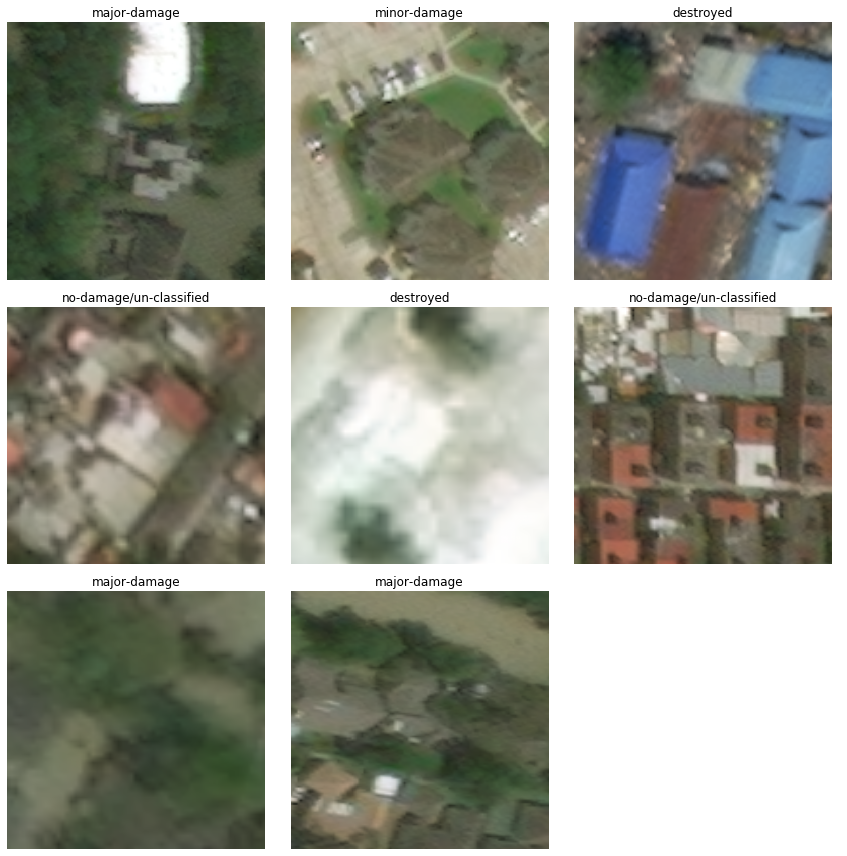

In [137]:
data.show_batch(rows=4, figsize=(12, 12), ds_type=DatasetType.Valid)

In [138]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

### Training

In [139]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [140]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

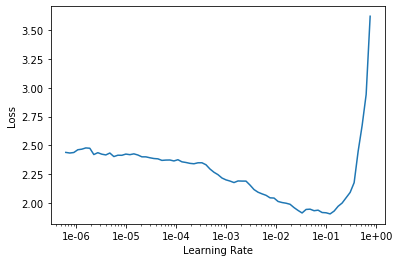

In [59]:
learn.recorder.plot()

In [60]:
lr = 1e-2

In [61]:
learn.fit_one_cycle(1, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.770817,0.861595,0.258427,00:19


In [63]:
learn.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.009323,0.818459,0.213483,00:17
1,0.881529,1.472590,0.337079,00:17
2,0.875073,0.637081,0.269663,00:17
3,0.767877,0.471066,0.202247,00:17
4,0.671327,0.450524,0.202247,00:17


In [64]:
learn.fit_one_cycle(10, max_lr=lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.507649,0.482108,0.168539,00:17
1,0.543812,0.628817,0.168539,00:17
2,0.597118,1.048085,0.303371,00:17
3,0.660338,0.760741,0.247191,00:17
4,0.621974,0.431341,0.179775,00:17
5,0.605951,0.430387,0.202247,00:17
6,0.554475,0.285629,0.123596,00:17
7,0.510151,0.302275,0.123596,00:17
8,0.457609,0.271911,0.101124,00:17
9,0.417087,0.280145,0.101124,00:17


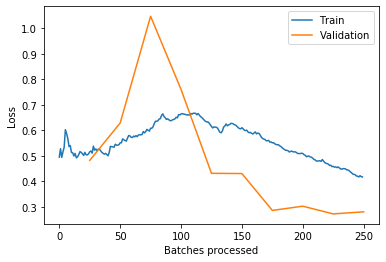

In [65]:
learn.recorder.plot_losses()

In [80]:
learn.save('classifier_sz512_bs32_resnet50_stage1')  #'damg_classifier_sz64.pth') #'classifier_sz512_bs32_resnet50_stage1')
learn.load('classifier_sz512_bs32_resnet50_stage1');  #'damg_classifier_sz64.pth'); #'classifier_sz512_bs32_resnet50_stage1');

In [90]:
learn.export('damage_classifier.pkl')

### Infer on single image

In [94]:
idx = 15
img = open_image(data.valid_ds.items[idx])

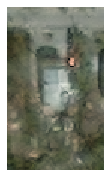

In [95]:
img.show()

In [86]:
learn.predict(img)

(Category no-damage/un-classified,
 tensor(0),
 tensor([0.8909, 0.0076, 0.0885, 0.0130]))

### Infer on 10 images

In [87]:
preds, pred_classes = [], []
for fn in progress_bar(data.valid_ds.items[:10]):
    img = open_image(fn)
    pred_class, pred_idx, outputs = learn.predict(img)
    preds.append(list(to_np(outputs)))
    pred_classes.append(str(pred_class))

In [88]:
uids = [o.stem for o in list(data.valid_ds.items[:10])]

In [89]:
pd.DataFrame({'uid':uids, 'pred_class':pred_classes})

,uid,pred_class
0,7be7d8a9-d284-4e42-8793-ce7b7b588219,no-damage/un-classified
1,0d187a0d-398b-4339-a54a-27695ffdfee3,no-damage/un-classified
2,dbc44cd2-b613-4495-8a43-8fff5f7f386a,no-damage/un-classified
3,e2ea9772-491c-4175-8f46-0d45dd404ebc,no-damage/un-classified
4,c1282575-3ca1-4965-a949-afecb9a00c56,major-damage
5,d3dfe5d5-9961-467f-a1ac-e0c84f33cd96,no-damage/un-classified
6,2ed65af9-5dfc-47e1-be2c-a9f7d4eeb0ca,no-damage/un-classified
7,e8cfe949-936a-4d40-a176-f22f739be4d3,no-damage/un-classified
8,1bff6b4e-fdca-4ee4-a5a9-9cd28db8eaab,no-damage/un-classified
9,373fb963-c81b-4770-ad49-bc9dc3ad2e6c,no-damage/un-classified


### Infer single image (`load_learner`)

In [92]:
load_learn = load_learner('./', file='damage_classifier.pkl')

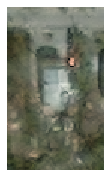

In [96]:
idx = 15
img = open_image(data.valid_ds.items[idx])
img.show()

In [97]:
load_learn.predict(img)

(Category no-damage/un-classified,
 tensor(0),
 tensor([0.8909, 0.0076, 0.0885, 0.0130]))

### Infer on 10 images (`load_learner`)

In [98]:
load_learn = load_learner('./', file='damage_classifier.pkl')

In [99]:
preds, pred_classes = [], []
for fn in progress_bar(data.valid_ds.items[:10]):
    img = open_image(fn)
    pred_class, pred_idx, outputs = load_learn.predict(img)
    preds.append(list(to_np(outputs)))
    pred_classes.append(str(pred_class))

In [101]:
pd.DataFrame({'uid':uids, 'pred_class':pred_classes})

,uid,pred_class
0,7be7d8a9-d284-4e42-8793-ce7b7b588219,no-damage/un-classified
1,0d187a0d-398b-4339-a54a-27695ffdfee3,no-damage/un-classified
2,dbc44cd2-b613-4495-8a43-8fff5f7f386a,no-damage/un-classified
3,e2ea9772-491c-4175-8f46-0d45dd404ebc,no-damage/un-classified
4,c1282575-3ca1-4965-a949-afecb9a00c56,major-damage
5,d3dfe5d5-9961-467f-a1ac-e0c84f33cd96,no-damage/un-classified
6,2ed65af9-5dfc-47e1-be2c-a9f7d4eeb0ca,no-damage/un-classified
7,e8cfe949-936a-4d40-a176-f22f739be4d3,no-damage/un-classified
8,1bff6b4e-fdca-4ee4-a5a9-9cd28db8eaab,no-damage/un-classified
9,373fb963-c81b-4770-ad49-bc9dc3ad2e6c,no-damage/un-classified


### Infer 10 images (`load_learner` and `get_preds`)

In [105]:
il = ImageList(data.valid_ds.items[:10])

In [106]:
load_learn = load_learner('./', file='damage_classifier.pkl', test=il)

In [107]:
pred_damg, y_damg = load_learn.get_preds(ds_type=DatasetType.Test)

In [111]:
pred_damg.argmax(dim=1)

tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [110]:
outputs

tensor([0.9100, 0.0037, 0.0434, 0.0429])

# -fin

In [68]:
! python notebook2script.py 03_damage_classification.ipynb

Converted 03_damage_classification.ipynb to xview2comp/nb_03.py
